In [1]:
import sys

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
  from google.colab import drive
  drive.mount('/content/drive')

  %cd /content/drive/MyDrive/KU_NLP
  !pip install -r requirements.txt

Mounted at /content/drive
/content/drive/MyDrive/KU_NLP
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 29.7 MB/s 
     |████████████████████████████████| 285 kB 71.2 MB/s 
     |████████████████████████████████| 691 kB 65.7 MB/s 
     |████████████████████████████████| 68 kB 7.3 MB/s 
     |████████████████████████████████| 115 kB 70.2 MB/s 
     |████████████████████████████████| 212 kB 72.9 MB/s 
     |████████████████████████████████| 163 kB 72.9 MB/s 
     |████████████████████████████████| 216 kB 73.3 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
     |████████████████████████████████| 127 kB 74.0 MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3162979 sha256=2d8400db578bf2771902475eaa6b249f883ad1bfff8575f014892c5b07740455
  Stored in directory: /root/.cache/pip/whe

# 2. Representation Learning

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from enum import Enum

import fasttext
import fasttext.util

import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

In [5]:
path_train_set = "data/train_set_stanza_compat.pkl"
path_validation_set = "data/validation_set_stanza_compat.pkl"

In [6]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [7]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

# 2a.

# 2b.

In [8]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED


In [9]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(data):
    answer_set = data['document_answer_region']
    y = np.empty(answer_set.shape[0], dtype=np.int32)

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [10]:
def token_to_id(token, tok2vec):
    assert OOV_id != None

    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id # OOV
    return id

In [11]:
def prepare_sample(question_tokens, document_tokens, tok2vec, question_max_length=512, document_max_length=1024):
    question_ids = [token_to_id(token, tok2vec) for token in question_tokens[:question_max_length]]
    document_ids = [token_to_id(token, tok2vec) for token in document_tokens[:document_max_length]]
    return question_ids, len(question_ids), document_ids, len(document_ids)

In [12]:
def pad_tokens(token_ids, token_lengths): # in a batch
    assert pad_id != None
    
    max_length = max(token_lengths)
    padded_ids = [(ids + [pad_id] * (max_length - len(ids))) for ids in token_ids]
    
    assert (all(len(padded) == max_length for padded in padded_ids))
    
    return padded_ids

def collate_into_batch(raw_batch):
    question_tokens = [sample[0] for sample in raw_batch]
    question_lengths = [sample[1] for sample in raw_batch]
    question_ids = pad_tokens(question_tokens, question_lengths)
    
    document_tokens = [sample[2] for sample in raw_batch]
    document_lengths = [sample[3] for sample in raw_batch]
    document_ids = pad_tokens(document_tokens, document_lengths)
    
    targets = [sample[4] for sample in raw_batch]

    return torch.tensor(question_ids), torch.tensor(question_lengths), torch.tensor(document_ids), torch.tensor(document_lengths), torch.tensor(targets, dtype=torch.long)

In [13]:
class QuestionAnsweredDatasetReader(Dataset):
    
    def __init__(self, df, tok2vec):
        self.df = df
        self.tok2vec = tok2vec
        self.targets = get_target(df)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.values[idx]
        question_tokens = row[1]
        document_tokens = row[3]
        target = self.targets[idx]
        
        question_ids, question_lengths, document_ids, document_lengths = prepare_sample(question_tokens, document_tokens, self.tok2vec)
        
        return question_ids, question_lengths, document_ids, document_lengths, target

In [14]:
class LSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(LSTM_Network, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True)
        self.linear = nn.Linear(2*lstm_dim, n_classes)

    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.word_embeddings(q_ids)
        lstm_out, _ = self.lstm(q_embeds)
        q_ff_in = torch.max(lstm_out, 1)[0]
        
        d_embeds = self.word_embeddings(d_ids)
        lstm_out, _ = self.lstm(d_embeds)
        d_ff_in = torch.max(lstm_out, 1)[0]
        
        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        logits = self.linear(ff_in)
        return logits


In [68]:
class BiLSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(BiLSTM_Network, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*2*lstm_dim, n_classes)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        q_ff_in = torch.max(lstm_out, 1)[0]

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        d_ff_in = torch.max(lstm_out, 1)[0]

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        logits = self.linear(ff_in)
        
        return logits

In [69]:
def prepare_embedding_matrix(embed_matrix):
    embed_dim = embed_matrix.shape[1]
    pad = torch.zeros(embed_dim, dtype=torch.float32)
    OOV = torch.zeros(embed_dim, dtype=torch.float32)
    embed_pre = torch.tensor(embed_matrix, dtype=torch.float32)
    
    OOV_id = embed_pre.shape[0]           
    pad_id = embed_pre.shape[0] + 1
                 
    return torch.vstack((embed_pre, pad, OOV)), pad_id, OOV_id

In [79]:
def test_forward_pass(model: nn.Module):
    """
    A simple function to quickly debug the net
    """
    # Test the forward pass with dummy data
    q = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    q_lengths = torch.tensor([3], dtype=torch.int).to(device)
    d = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    d_lengths = torch.tensor([3], dtype=torch.int).to(device)

    out = model.forward(q, q_lengths, d, d_lengths)

    print("Output shape:", out.size())
    print(f"Output logits:\n{out.cpu().detach().numpy()}")

In [80]:
def summarize_batch(token_ids, sequence_lengths):
    actual_length = torch.sum(sequence_lengths)
    total_length = np.sum([len(question) for question in token_ids])
    
    OOV_count = np.sum([torch.sum(question == OOV_id) for question in token_ids])
    print("OOV: {}/{}".format(OOV_count, total_length))
    
    pad_count = np.sum([torch.sum(question == pad_id) for question in token_ids])
    print("PAD: {}/{}".format(pad_count, total_length))   

In [171]:
def transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets):
  q_ids = q_ids.to(device)
  q_lengths = q_lengths.to(device)
  d_ids = d_ids.to(device)
  d_lengths = d_lengths.to(device)
  targets = targets.to(device)
  return q_ids, q_lengths, d_ids, d_lengths, targets     

In [208]:
def train(model: nn.Module, train_data, validation_data, n_epochs = 10, batch_size = 64):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters()) #, weight_decay=1e-6

    # Load dataset
    train_dataset = QuestionAnsweredDatasetReader(train_data, tok2vec)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_into_batch)

    val_dataset = QuestionAnsweredDatasetReader(validation_data, tok2vec)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_into_batch)

    # store improvement per epoch
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):

        ### Training
        model.train()

        # Store batch loss and accuracy
        loss_epoch = []
        accuracy_epoch = []

        batch_pbar = tqdm(train_dataloader)
        for q_ids, q_lengths, d_ids, d_lengths, targets in batch_pbar:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets)
            
            # training
            outputs = model(q_ids, q_lengths, d_ids, d_lengths)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # prediction
            predictions = outputs.max(1)[1]
            accuracy = accuracy_score(targets.cpu(), predictions.cpu())

            loss_epoch.append(loss.detach().cpu().item())
            accuracy_epoch.append(accuracy)

            batch_pbar.set_description(f"epoch={epoch+1}/{n_epochs} | loss={loss.item():.2f}, accuracy={accuracy:.2f}")

        train_loss = np.mean(loss_epoch)
        train_losses.append(train_loss)

        train_acc = np.mean(accuracy_epoch)
        train_accuracies.append(train_acc)

        ### Evaluation
        test_acc = evaluate(model, val_dataloader)
        test_accuracies.append(test_acc)

        print(f"epoch={epoch+1}/{n_epochs} | loss={train_loss:.2f}, train_accuracy={train_acc:.2f}, test_accuracy={test_acc:.2f}")

    print("Finished training.")
    
    return train_losses, train_accuracies, test_accuracies

In [209]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
    model.eval()

    logits_all = []
    targets_all = []

    with torch.no_grad():
        for q_ids, q_lengths, d_ids, d_lengths, targets in valid_dl:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets)

            logits = model(q_ids, q_lengths, d_ids, d_lengths)

            targets_all.extend(targets.detach().cpu().numpy())

            predictions = logits.max(1)[1].cpu()
            logits_all.extend(predictions)
            
        acc = accuracy_score(logits_all, targets_all)

    return acc

In [210]:
def plot_network_learning(model_name, train_accuracies, test_accuracies, train_losses=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.grid(linestyle="--")
    ax.set_title(model_name)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")

    epoch_range = np.arange(len(train_accuracies), step=1)
    ax.plot(epoch_range, train_accuracies)
    ax.plot(epoch_range, test_accuracies)
    ax.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    
    ax.set_yticks(np.linspace(0.5, 1, 11))
    ax.set_xticks(epoch_range)
    
    if train_losses != None:
        ax2 = ax.twinx()
        ax2.plot(epoch_range, train_losses, c="g")
        ax2.set_yticks(np.linspace(0, 1, 11))
        ax2.set_ylabel("Loss")
        ax2.legend(["Train Loss"], loc="upper right")

In [211]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [212]:
device

device(type='cuda')

## English

In [219]:
# Setup Model
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = BiLSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
)


In [214]:
test_forward_pass(model)

Output shape: torch.Size([1, 2])
Output logits:
[[ 0.05235444 -0.01755815]]


In [220]:
train_result_en = train(model, train_en, validation_en)

epoch=1/10 | loss=0.64, accuracy=0.66: 100%|██████████| 116/116 [00:07<00:00, 15.78it/s]


epoch=1/10 | loss=0.66, train_accuracy=0.61, test_accuracy=0.53


epoch=2/10 | loss=0.59, accuracy=0.72: 100%|██████████| 116/116 [00:07<00:00, 15.78it/s]


epoch=2/10 | loss=0.57, train_accuracy=0.71, test_accuracy=0.72


epoch=3/10 | loss=0.50, accuracy=0.76: 100%|██████████| 116/116 [00:06<00:00, 17.47it/s]


epoch=3/10 | loss=0.52, train_accuracy=0.75, test_accuracy=0.77


epoch=4/10 | loss=0.46, accuracy=0.83: 100%|██████████| 116/116 [00:06<00:00, 17.50it/s]


epoch=4/10 | loss=0.48, train_accuracy=0.78, test_accuracy=0.78


epoch=5/10 | loss=0.29, accuracy=0.93: 100%|██████████| 116/116 [00:06<00:00, 17.64it/s]


epoch=5/10 | loss=0.46, train_accuracy=0.79, test_accuracy=0.79


epoch=6/10 | loss=0.47, accuracy=0.79: 100%|██████████| 116/116 [00:06<00:00, 17.54it/s]


epoch=6/10 | loss=0.44, train_accuracy=0.80, test_accuracy=0.80


epoch=7/10 | loss=0.40, accuracy=0.83: 100%|██████████| 116/116 [00:07<00:00, 15.32it/s]


epoch=7/10 | loss=0.43, train_accuracy=0.80, test_accuracy=0.79


epoch=8/10 | loss=0.53, accuracy=0.79: 100%|██████████| 116/116 [00:06<00:00, 16.74it/s]


epoch=8/10 | loss=0.42, train_accuracy=0.81, test_accuracy=0.78


epoch=9/10 | loss=0.59, accuracy=0.62: 100%|██████████| 116/116 [00:06<00:00, 17.34it/s]


epoch=9/10 | loss=0.41, train_accuracy=0.82, test_accuracy=0.79


epoch=10/10 | loss=0.31, accuracy=0.86: 100%|██████████| 116/116 [00:06<00:00, 17.55it/s]


epoch=10/10 | loss=0.39, train_accuracy=0.83, test_accuracy=0.81
Finished training.


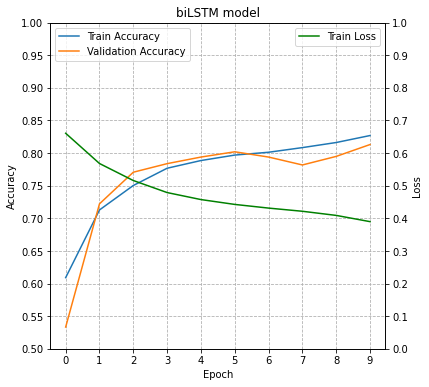

In [221]:
train_losses, train_accuracies, test_accuracies = train_result_en
plot_network_learning("biLSTM model", train_accuracies, test_accuracies, train_losses)

## Finnish

In [222]:
# Setup Model
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("fasttext-fi-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = BiLSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
)


In [223]:
train_result_fi = train(model, train_fi, validation_fi)

epoch=1/10 | loss=0.58, accuracy=0.40: 100%|██████████| 215/215 [00:07<00:00, 26.90it/s]


epoch=1/10 | loss=0.57, train_accuracy=0.68, test_accuracy=0.73


epoch=2/10 | loss=0.28, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.31it/s]


epoch=2/10 | loss=0.49, train_accuracy=0.76, test_accuracy=0.75


epoch=3/10 | loss=0.14, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.19it/s]


epoch=3/10 | loss=0.45, train_accuracy=0.78, test_accuracy=0.76


epoch=4/10 | loss=0.15, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.14it/s]


epoch=4/10 | loss=0.44, train_accuracy=0.79, test_accuracy=0.77


epoch=5/10 | loss=0.25, accuracy=0.80: 100%|██████████| 215/215 [00:07<00:00, 27.42it/s]


epoch=5/10 | loss=0.43, train_accuracy=0.79, test_accuracy=0.78


epoch=6/10 | loss=0.35, accuracy=0.80: 100%|██████████| 215/215 [00:07<00:00, 27.64it/s]


epoch=6/10 | loss=0.41, train_accuracy=0.81, test_accuracy=0.77


epoch=7/10 | loss=0.11, accuracy=1.00: 100%|██████████| 215/215 [00:07<00:00, 27.39it/s]


epoch=7/10 | loss=0.40, train_accuracy=0.82, test_accuracy=0.77


epoch=8/10 | loss=0.91, accuracy=0.40: 100%|██████████| 215/215 [00:07<00:00, 27.38it/s]


epoch=8/10 | loss=0.39, train_accuracy=0.82, test_accuracy=0.78


epoch=9/10 | loss=0.08, accuracy=1.00: 100%|██████████| 215/215 [00:08<00:00, 26.84it/s]


epoch=9/10 | loss=0.38, train_accuracy=0.83, test_accuracy=0.77


epoch=10/10 | loss=0.20, accuracy=1.00: 100%|██████████| 215/215 [00:08<00:00, 24.34it/s]


epoch=10/10 | loss=0.35, train_accuracy=0.84, test_accuracy=0.76
Finished training.


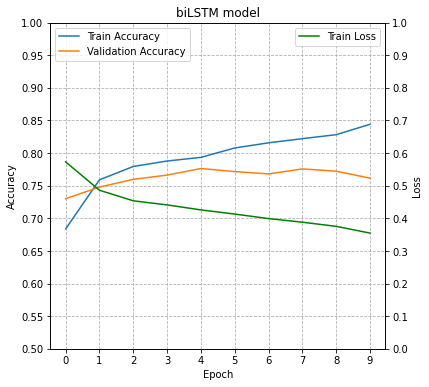

In [224]:
train_losses, train_accuracies, test_accuracies = train_result_fi
plot_network_learning("biLSTM model", train_accuracies, test_accuracies, train_losses)

## Japanese

In [225]:
# Setup Model
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("fasttext-ja-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = BiLSTM_Network(pretrained_embeddings)
model.to(device)

print(model)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
)


In [226]:
train_result_ja = train(model, train_ja, validation_ja)

epoch=1/10 | loss=0.67, accuracy=0.60: 100%|██████████| 138/138 [00:11<00:00, 12.12it/s]


epoch=1/10 | loss=0.65, train_accuracy=0.61, test_accuracy=0.60


epoch=2/10 | loss=0.81, accuracy=0.50: 100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


epoch=2/10 | loss=0.59, train_accuracy=0.68, test_accuracy=0.67


epoch=3/10 | loss=0.48, accuracy=0.90: 100%|██████████| 138/138 [00:12<00:00, 11.46it/s]


epoch=3/10 | loss=0.54, train_accuracy=0.72, test_accuracy=0.71


epoch=4/10 | loss=0.66, accuracy=0.70: 100%|██████████| 138/138 [00:11<00:00, 12.12it/s]


epoch=4/10 | loss=0.51, train_accuracy=0.75, test_accuracy=0.73


epoch=5/10 | loss=0.37, accuracy=0.80: 100%|██████████| 138/138 [00:11<00:00, 12.17it/s]


epoch=5/10 | loss=0.48, train_accuracy=0.77, test_accuracy=0.72


epoch=6/10 | loss=0.23, accuracy=0.90: 100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


epoch=6/10 | loss=0.47, train_accuracy=0.78, test_accuracy=0.74


epoch=7/10 | loss=0.41, accuracy=0.70: 100%|██████████| 138/138 [00:11<00:00, 12.05it/s]


epoch=7/10 | loss=0.45, train_accuracy=0.79, test_accuracy=0.72


epoch=8/10 | loss=0.60, accuracy=0.80: 100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


epoch=8/10 | loss=0.44, train_accuracy=0.80, test_accuracy=0.75


epoch=9/10 | loss=0.56, accuracy=0.80: 100%|██████████| 138/138 [00:11<00:00, 12.19it/s]


epoch=9/10 | loss=0.42, train_accuracy=0.81, test_accuracy=0.75


epoch=10/10 | loss=0.40, accuracy=0.90: 100%|██████████| 138/138 [00:11<00:00, 12.17it/s]


epoch=10/10 | loss=0.40, train_accuracy=0.82, test_accuracy=0.76
Finished training.


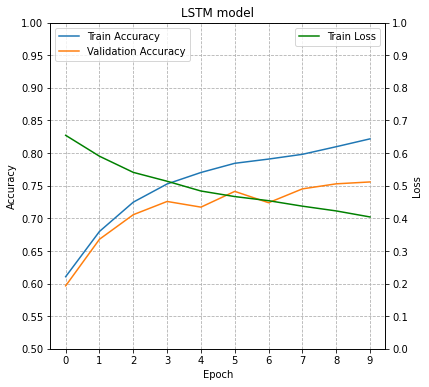

In [227]:
train_losses, train_accuracies, test_accuracies = train_result_ja
plot_network_learning("LSTM model", train_accuracies, test_accuracies, train_losses)

## Misc

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
ft.get_dimension()
ft.get_word_vector('king').shape

fasttext.util.reduce_model(ft, 80)
ft.get_dimension()

"asdasdsad" in ft.words
ft.get_nearest_neighbors('cookie')

[(0.8153295516967773, 'cupcake'),
 (0.7879170179367065, 'cookie-'),
 (0.7691606879234314, 'cookies'),
 (0.760718047618866, 'cake'),
 (0.7547473907470703, 'popover'),
 (0.7430337071418762, 'non-cookie'),
 (0.7359125018119812, 'cakepop'),
 (0.7353752255439758, 'muffin'),
 (0.7349858283996582, 'cookie.'),
 (0.7314939498901367, 'cookie.The')]

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
nlp.vocab["old"].vector.shape

(300,)

https://github.com/pytorch/text/issues/1350
https://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html

In [ ]:
small_model.most_similar("quantum")

[('Quantum', 0.5923356945161),
 ('physics', 0.4987263608889812),
 ('computational', 0.4833229306372649),
 ('cosmic', 0.46287664812730667),
 ('atomic', 0.4555259364535978),
 ('atoms', 0.4543258391303013),
 ('electron', 0.4415847215404407),
 ('electromagnetic', 0.4342020722504953),
 ('optical', 0.4341506741975586),
 ('physicist', 0.43388256332181196)]